In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import chi2
import seaborn as sns
from pprint import pprint
import time
from timeit import default_timer as timer

import string
import re
from stop_words import get_stop_words
import nltk, html

from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, train_test_split, ParameterGrid, KFold, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [3]:
''' ******Data Creation******'''

df = pd.read_csv(r'Desktop\development.csv')

X = df['text']
y = df['sentiment']

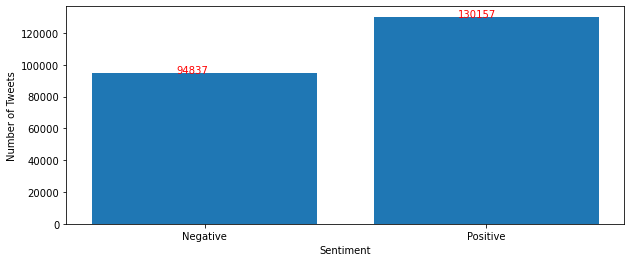

In [4]:
''' ******Data Exploration****** '''

count = Counter(y)
labels = ['Positive', 'Negative']
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(count.keys(), count.values(), tick_label = labels)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets')
#fig.suptitle('Number of tweets in Category')
for index, data in enumerate(sorted(count.values())):
    plt.text(x = index - .1 , y = data + 2 , s=f"{data}" , fontdict=dict(fontsize=10), color='red')
plt.show()

In [5]:
''' ******Feature Engineering******'''

# =============Text Cleaning=============
stop_words = get_stop_words('english')
#instantiation for stemming
lemma = nltk.wordnet.WordNetLemmatizer()

def tokenize(doc):
    """Compute the tokens for each document.

    Input: a list of strings. Each item is a document to tokenize.
    Output: a list of lists. Each item is a list containing the tokens of the relative document.
    """
    tokens = []
    for tweet in doc:
        
        tweet = html.unescape(tweet) # Escaping out HTML characters
        tweet = tweet.replace('"', '') # quoting
        tweet = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", tweet) # removing email
        tweet = re.sub("(.)\\1{2,}", "\\1", tweet) # removing repeatetive letters in a word
        tweet = " ".join(tweet.split()) 
        tweet=tweet.lower() # convert to lower case
        split_doc = [lemma.lemmatize(token) for token in tweet.split(" ") if ((token not in stop_words) and (token not in string.punctuation))]
        target = ' '.join(split_doc) # getting sentence from a list
        
        tokens.append(target) # adding to final list
    return tokens

X_token = tokenize(X)

In [6]:
# =============Null Check=============
null_check = pd.Series(X_token)
print('number of null values in records: ', len(null_check[null_check.isna()]))

number of null values in records:  0


In [7]:
# =============Train-Test Split=============
X_train, X_test, y_train, y_test = train_test_split(X_token, y, test_size=.2, stratify=y, shuffle=True, random_state=42)

In [8]:
# =============Text Representation/Feature Creation=============
tfidf = TfidfVectorizer(max_features=8000, lowercase=False, sublinear_tf=True)
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)

(179995, 8000)
(44999, 8000)


In [9]:
# =============Cosine Similarity=============
cosine_similarities = linear_kernel(features_train[0:1], features_train).flatten()
print(cosine_similarities[:10])

[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.10283705]


In [10]:
''' ******Model Learning KNN******'''

# =============KNN=============
# Create a base model
knnc = KNeighborsClassifier()
# =============Cross-Validation for Hyperparameter Tuning=============
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]

param_grid = {'n_neighbors': n_neighbors}

In [13]:
# ============= Grid Search Cross-Validation=============

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train[:30000], labels_train[:30000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20]},
             scoring='f1_macro', verbose=1)

In [14]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 5}

The mean accuracy of a model with these hyperparameters is:
0.5488821272595015


In [20]:
# =============Best Model=============
best_knnc = grid_search.best_estimator_
best_knnc = KNeighborsClassifier(n_neighbors = 5)
best_knnc

KNeighborsClassifier()

In [16]:
'''testing the whole data by founded hyperparameters'''

'testing the whole data by founded hyperparameters'

In [21]:
# =============Model Fitting and Performance=============
best_knnc.fit(features_train, labels_train)

start = timer()
knnc_pred = best_knnc.predict(features_test)
end = timer()
print('time is: ',end-start)

time is:  146.41753190000009


In [23]:
# =============Test Accuracy=============
print("The test accuracy is: ")
print(f1_score(labels_test, knnc_pred, average='macro'))

The test accuracy is: 
0.6131573474099439


In [25]:
# =============Classification Report=============
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.58      0.47      0.52     18967
           1       0.66      0.76      0.71     26032

    accuracy                           0.64     44999
   macro avg       0.62      0.61      0.61     44999
weighted avg       0.63      0.64      0.63     44999



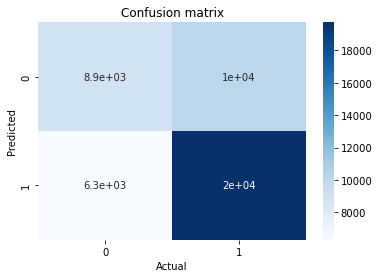

In [26]:
# =============Confusion Matrix=============
conf_matrix = confusion_matrix(labels_test, knnc_pred)
sns.heatmap(conf_matrix, 
            annot=True,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()